In [48]:
from parallel_wavegan.utils import read_hdf5

mu = read_hdf5(hdf5_name='/TransformerTTS/vocoder/parallel_wavegan/stats.h5', hdf5_path='mean')
sigma = read_hdf5(hdf5_name='/TransformerTTS/vocoder/parallel_wavegan/stats.h5', hdf5_path='scale')

In [50]:
import numpy as np
import librosa

def melspectrogram(path: str):
    y, sr = librosa.load(path, sr=22050)

    # pre emphasis
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])

    # spectrogram
    S = librosa.stft(y, n_fft=1024, hop_length=256)
    D = np.abs(S)

    # melspectrogram
    mel_filter = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
    mel = np.dot(mel_filter, D)
    log_mel = np.log10(np.clip(mel, a_min=1e-5, a_max=None))

    return log_mel


def normalize(log_mel, mu, sigma):
    return (log_mel - mu[:, np.newaxis]) / np.sqrt(sigma[:, np.newaxis])



In [51]:
from tqdm import tqdm

with open("/TransformerTTS/data/metadata.csv", "r") as f:

    global_mu, global_var = [], []

    for line in tqdm(f.readlines()):
        aid, _, _ = line.strip().split("|")
        apath = "/TransformerTTS/data/wavs/{}.wav".format(aid)
        log_mel = melspectrogram(apath)

        global_mu.append(np.mean(log_mel, axis=1))
        global_var.append(np.var(log_mel, axis=1))

    mu = np.mean(global_mu, axis=0)
    var = np.mean(global_var, axis=0)

    print("Mean")
    print(mu)

    print("Variance")
    print(var)

    np.save("/TransformerTTS/vocoder/pre_mu.npy", mu)
    np.save("/TransformerTTS/vocoder/pre_var.npy", var)


100%|██████████| 13100/13100 [04:51<00:00, 44.96it/s]


Mean
[-3.5493228 -3.077814  -2.843193  -2.764179  -2.675267  -2.6927435
 -2.6602914 -2.5670536 -2.5659847 -2.4588919 -2.388478  -2.4142256
 -2.4189272 -2.4495475 -2.5277798 -2.533128  -2.5449529 -2.5965314
 -2.6073327 -2.6727722 -2.773411  -2.7766347 -2.8021805 -2.8343825
 -2.7993114 -2.8217218 -2.8294191 -2.8591015 -2.8858755 -2.8974617
 -2.931675  -2.958278  -2.9702318 -2.9728217 -2.944018  -2.9206412
 -2.8290317 -2.7991838 -2.769792  -2.7347355 -2.6994848 -2.675785
 -2.6894188 -2.7317958 -2.7577205 -2.8090847 -2.825741  -2.8241227
 -2.805831  -2.7778385 -2.7428796 -2.7072287 -2.6528664 -2.6046526
 -2.5885508 -2.5981784 -2.617148  -2.631267  -2.626953  -2.6032536
 -2.5765235 -2.5660412 -2.5643754 -2.581536  -2.6008666 -2.6163266
 -2.6268332 -2.63837   -2.6451113 -2.6923175 -2.782949  -2.8918335
 -2.9706147 -3.0248106 -3.0247772 -2.9980168 -2.9290254 -2.8281128
 -2.724678  -2.6543834]
Variance
[0.19001493 0.4482851  0.6055313  0.5873303  0.51508284 0.5162731
 0.5997283  0.64534336 0.6

In [65]:
path = "/TransformerTTS/data/wavs/LJ001-0001.wav"

log_mel = melspectrogram(path)

mu = np.load("/TransformerTTS/vocoder/pre_mu.npy")
var = np.load("/TransformerTTS/vocoder/pre_var.npy")

melspec = (log_mel - mu[:, np.newaxis]) / np.sqrt(var[:, np.newaxis])

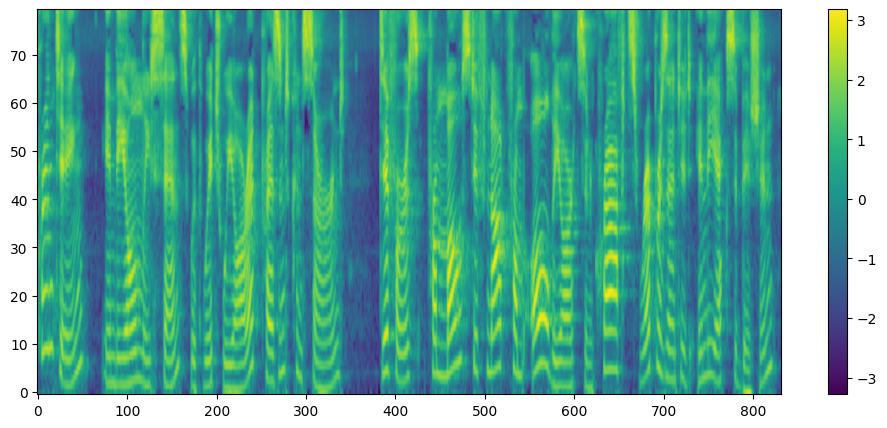

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.imshow(melspec, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [69]:
from parallel_wavegan.utils import load_model
from IPython.display import Audio
import torch
from scipy import signal

vocoder = load_model("/TransformerTTS/vocoder/parallel_wavegan/checkpoint-3000000steps.pkl").to('cuda').eval()
vocoder.remove_weight_norm()
_ = vocoder.eval()

x = torch.FloatTensor(melspec.T).cuda()
out = vocoder.inference(x).view(-1).detach().cpu().numpy()

out = signal.lfilter([1], [1, -0.97], out)

Audio(out, rate=22050)

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [43]:
Audio(y, rate=22050)